# Modelling with Linear Regression

## How Linear Regression Benefits an Art Auction Dataset

**Understanding Linear Regression:**
- **Simple and Easy to Interpret:** Linear regression finds a straight-line relationship between factors (like artist, year, or style) and auction prices. This makes it easy to see how each factor affects the price.
- **Quick and Lightweight:** It requires less computational power, which is great for quick insights and initial analysis.
- **Clear Insights:** The coefficients show the impact of each feature, making the results easy to explain and understand.

**Why Use Bootstrapping:**
- **Small Dataset Challenge:** When there isn't a lot of data, the model might not learn enough about the underlying patterns.
- **Creating More Data:** Bootstrapping helps by randomly sampling the existing data (with replacement) to create many "mini-datasets." This lets the model train on slightly different versions of the data.
- **Increased Reliability:** By training on these different samples, bootstrapping provides more robust estimates and helps gauge the uncertainty in the predictions.

In [4]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

# Load data from CSV (using latin1 encoding)
df = pd.read_csv("auction_data_cleaned draft 1.2.csv", encoding="latin1")

# Remove rows with missing (null) values 
df = df.dropna()

# Display how many rows are left after dropping missing values for context
print("Shape after dropping missing values:", df.shape)

# Use bootstrapping to increase the sample size by 5x
df = df.sample(n=len(df) * 5, replace=True, random_state=42)

# Drop outliers based on Z-scores
# Select numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=["int", "float"]).columns

# Compute Z-scores for the numeric columns
z_scores = df[numeric_cols].apply(zscore)

# Filter the DataFrame: keep rows where the absolute Z-score of every numeric column is <= 3 to remove extreme values
df = df[(z_scores.abs() <= 3).all(axis=1)]
print("Shape after dropping outliers:", df.shape)

# Use '-1' position as the target variable is the last column and the rest are features
# Drop the target variable, which is the final price in X to prevent overfitting
target_column = df.columns[-1]
X = df.drop(target_column, axis=1)
y = df[target_column]

# Convert text-based categorical columns into dummy variables
X = pd.get_dummies(X)

# Function to scale numeric features while excluding specified columns
def scale_numeric_columns(x, exclude_columns=["critically_acclaimed", "is_artwork_sold", "is_artist_deceased",
                                               "sold_below_low_estimate", "sold_above_high_estimate",
                                               "sold_above_median_estimate"]):
    # Select numeric columns (int and float) excluding the specified columns
    numeric_cols = x.select_dtypes(include=["int", "float"]).columns.difference(exclude_columns)
    scaler = StandardScaler()
    # Scale the selected numeric columns in the provided DataFrame 'x'
    x[numeric_cols] = scaler.fit_transform(x[numeric_cols])
    return x

# Apply scaling to a copy of the DataFrame
x_scaled = scale_numeric_columns(X.copy())

# Split the data equally into training and testing sets (50% each)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate R² scores to measure how well the model fits the data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate RMSE to quantify the prediction error
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print("Training R2:", round(train_r2, 2))
print("Test R2:", round(test_r2, 2))
print("Training RMSE:", round(train_rmse, 2))
print("Test RMSE:", round(test_rmse))


Shape after dropping missing values: (199, 29)
Shape after dropping outliers: (866, 29)
Training R2: 1.0
Test R2: 0.97
Training RMSE: 0.0
Test RMSE: 2986


## Visualise Result

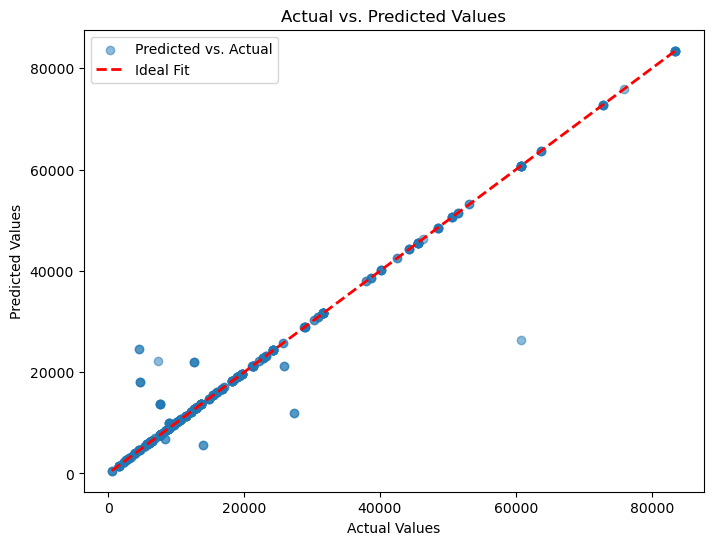

In [6]:
# Create scatter plot for the test set
# Set a specified size for the scatter plot
plt.figure(figsize=(8, 6))

# Plot the scatter of actual vs. predicted values for the test set,
# Using a semi-transparent marker for better visualization of overlapping points.
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Predicted vs. Actual')

# Plot a red dashed line representing the ideal scenario where predicted values equal actual values.
# Use y_test.min() and y_test.max() to define the endpoints of the "best fitting" line, which represents perfect prediction.
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')

# Label the axis and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Display a legend
plt.legend()
plt.show()


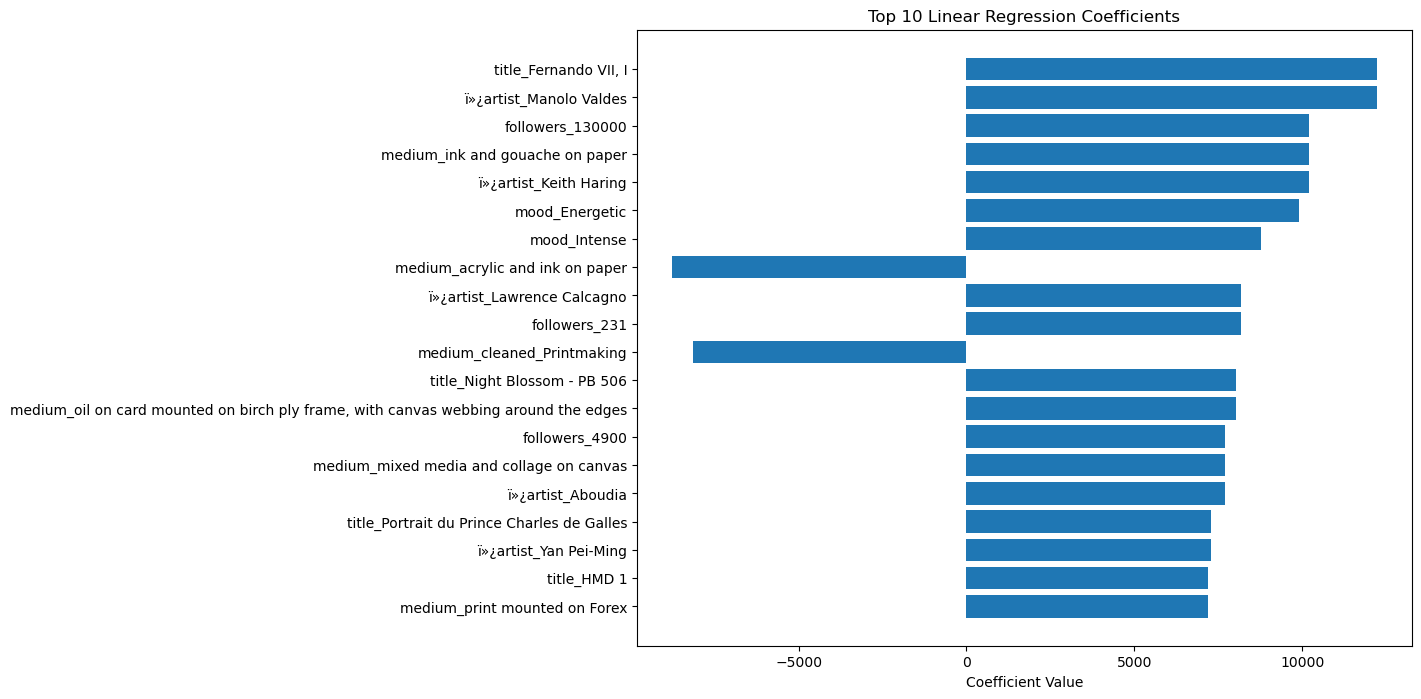

In [9]:
# Compute the model coefficients to understand the relationship between features and the target
coefficients = model.coef_
features = X.columns # Extract feature names from the dataset

# Create a DataFrame pairing each feature with its corresponding coefficient
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Add a column for the absolute values of coefficients for proper sorting
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Select the top 20 features by absolute coefficient value and sort them in ascending order
top20 = coef_df.nlargest(20, 'Abs_Coefficient').sort_values(by='Abs_Coefficient', ascending=True)

# Plot a horizontal bar chart displaying the top 20 coefficients
plt.figure(figsize=(10, 8))
plt.barh(top20['Feature'], top20['Coefficient'])

# Label the axis and title
plt.xlabel("Coefficient Value")
plt.title("Top 10 Linear Regression Coefficients")
plt.show()